# PROBLEM DEFINITION

Time series forecasting is one of the biggest challenges in ML. Many have tried to forecast the stock market and many have failed.
The original goal is to predict the stock price of a market or a company to see if it is worth investing in that stock.
I want to show that we can approach this problem with a different approach.

My goal:
- Find an alternative approach to find the right moment to invest with the help of AI


This approach does not try to predict the exact value of the stock price but it tries to classify or time-series, so that we know if it is a good time to invest or not.
<br>
For this we will use some feature engineering to label our data in
- Class 0: Mean stock price for the next 45 days is lower as the stock price of the last 45 days
- Class 1: Mean stock price for the next 45 days is higher as the stock price of the last 45 days 


Further we will use an algorithm to extract low dimensional features from our time-series (for more information see chapter ). The idea is inspired by this paper:
Ye, L., Keogh, E. Time series shapelets: a novel technique that allows accurate, interpretable and fast classification. Data Min Knowl Disc 22, 149–182 (2011). https://doi.org/10.1007/s10618-010-0179-5
<br>
The implementation of this algorithm can be found here:
https://github.com/papelero/greedy_shapelets

Then we will use these low dimensional features to classify our data with basic ML classification models.





----------------------------------------------------------------------------------------------------------------------------------
Note on Run-Time:
<br>
Calculating the shapelets can take some time. I tried to limit it by just calculating 3 shapelets. Anyway I highly recommend to skip this calculation and to use the existing model.

----------------------------------------------------------------------------------------------------------------------------------------
For financial references see:
<br>
Long position to bet on rising share prices: https://en.wikipedia.org/wiki/Long_(finance)
<br>
Short position to bet on falling share prices: https://en.wikipedia.org/wiki/Short_(finance)


# 1. PREPARING THE ENVIRONMENT

In [159]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd


from utils.algorithm import GreedyShapeletSearch
from utils.pipeline import features_transform, fit_classifier, train_predict

# 2 DATA EXPLORATION AND PREPARATION

## 2.1 PRE-PROCESSING

Here we upload the stock data from Apple. The data has been selected randomly. But 

In [160]:
df = pd.read_csv('aapl.txt', sep=",", header=0, index_col=False)
#data.columns = ["a", "b", "c", "etc."]

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     8364 non-null   object 
 1   Open     8364 non-null   float64
 2   High     8364 non-null   float64
 3   Low      8364 non-null   float64
 4   Close    8364 non-null   float64
 5   Volume   8364 non-null   int64  
 6   OpenInt  8364 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 457.5+ KB


The data looks clean. We do not have to drop any NaN values.

## 2.2 EXPLORE THE DATA

Let's first see what the data looks like. The tail and head of the data will give us a first impression of the development of the data.

In [162]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [163]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
8359,2017-11-06,171.75,174.36,171.10,173.63,34901241,0
8360,2017-11-07,173.29,174.51,173.29,174.18,24424877,0
8361,2017-11-08,174.03,175.61,173.71,175.61,24451166,0
8362,2017-11-09,174.48,175.46,172.52,175.25,29533086,0
8363,2017-11-10,175.11,175.38,174.27,174.67,25130494,0


Let's check for NaN values:

In [164]:
df.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [165]:
def plot_stock_data(data_x, data_y):
    '''
    Plot the stock data.

    Parameters:
    -----------

    data_x : Pandas DataFrame/ Series
        Data for x-Axis. Must be Date!
    data_y : Pandas DataFrame/ Series
        Data for y-Axis 

    Raises:
    -------
    ValueError if Input data is not a pandas Series   
    '''
    if not (isinstance(data_x, pd.core.series.Series) or isinstance(data_y, pd.core.series.Series)):
        raise ValueError('Input data must be pandas Series')

    # get all years
    df_start = pd.to_datetime(df['Date'].iloc[0])
    df_end = pd.to_datetime(df['Date'].iloc[-1])
    delta = df_end.year - df_start.year

    # plot 
    plt.figure(figsize=(20,10))
    plt.plot(data_x, data_y)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(delta//2))  # all years // 2
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    ax.margins(x=0.01)
    ax.set_facecolor('lightgrey')
    plt.xlabel('Year', size=15)
    plt.ylabel('Stock Price [USD]', size=15)
    plt.title('APPLE STOCK PRICE DAILY HIGH', size=20)

    plt.show()

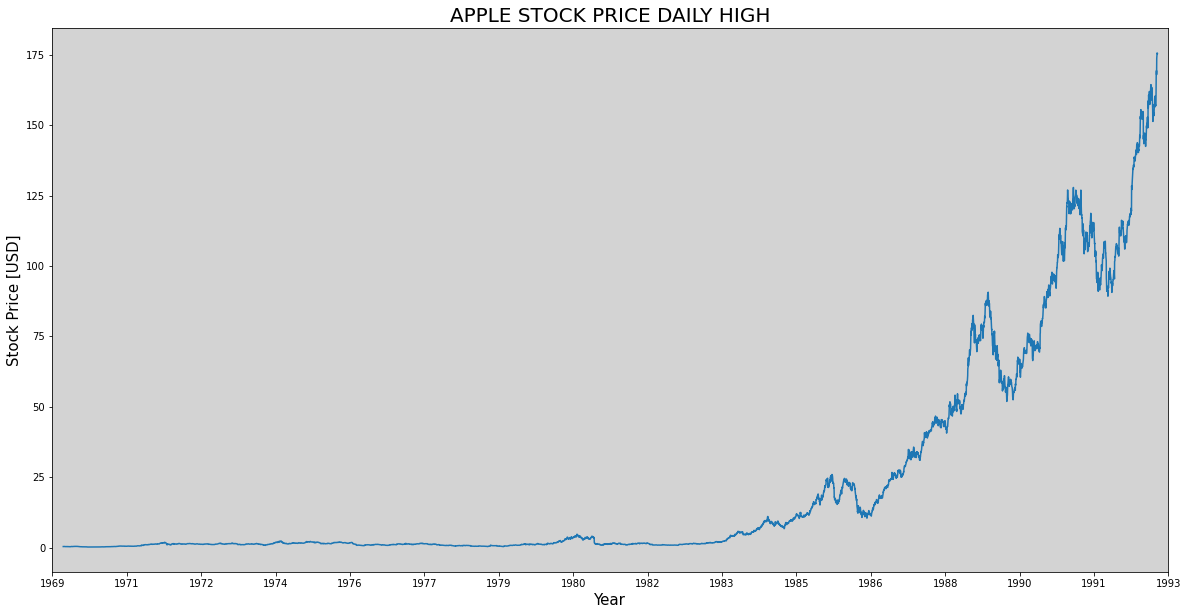

In [166]:
plot_stock_data(df['Date'], df['High'])

We can see that the data does not have any outlier as expected.

## 2.3 FEATURE ENGINEERING

Our goal is to create a target array Y and to split our time series into subsequences. Later we will extract from every subsequence low dim. features. This will create our feature array X. 

In [167]:
class DataPreProcessor():
    '''
    Create new object for labelling data and split time series into evenly splitted subsequences.

    Parameters:
    -----------
    ser : Pandas Series
        Time series to train the algortihm on
    subseq_len : int
        Len of subsequences
    calculate_max = bool, Default = True
        Bool whether to take the max or the mean value for comparison of subseq[i] and subseq[i+1]


    '''

    def __init__(self, ser, subseq_len=60, calculate_max=False):
        self.ser = ser
        self.subseq_len = subseq_len
        self.ser_truncated = None

        # define evaluating function for prediction horizon: mean vs max
        if calculate_max: 
            self.eval_func = self.get_max
        else: 
            self.eval_func = self.get_mean


    def split_ser_into_subsequences(self):
        '''
        Splits the series into subsequences.
        If series cannot be splitted evenly, i.e. every subsequence has the same length, the series is truncated.

        Returns:
        --------
        subseq-arrays : list of ndarrays
            List of subsequences in chronological order. 
        '''
        min_num_subseq = 100 # at least 100 instances to train the models -> arbitray choosen
        mod = len(self.ser)%self.subseq_len

        if len(self.ser)/self.subseq_len < min_num_subseq:
            raise Warning('Series is not long enough. Model will be trained with less than 100 instances!')
        if mod == 0:
            return np.array_split(self.ser, len(self.ser)/self.subseq_len)
        # truncate series so that it can be splitted evenly
        self.ser_truncated = self.ser.iloc[mod:]
        return np.array_split(self.ser_truncated, len(self.ser_truncated)/self.subseq_len)
    

    def label_data(self):
        '''
        Returns:
        -------
        y : np.array
            Labelled array with 1 if next periodes (pred_horizon) max value/ mean value is greater than the previous
        '''
        X = self.split_ser_into_subsequences()
        return np.array( [ 1 if self.eval_func(X[i+1])>self.eval_func(X[i]) else 0 for i in range(0, len(X) -1 ) ] )
    

    def get_max(self, x):
        '''
        Get the max value of a given series for a given prediction horizon.

        Params:
        -------
        x : Pandas Series
            Arbitary Subsequence 

        Returns:
        --------
        max-value : int
            Max value of the given subsequence
        ''' 
        return np.max(x)


    def get_mean(self, x):
        '''
        Get the mean value of a given series for a given prediction horizon.

        Params:
        -------
        x : Pandas Series
            Arbitary Subsequence 

        Returns:
        --------
        mean-value : int
            mean value of the given subsequence
        ''' 
        return np.mean(x)
    

    def get_train_test_split(self):
        '''
        This Method returns the train and test set. See Returns!

        Note: The array of subsequences is truncated since the last subsequence cannot be labeled.  

        Returns
        -------
        splitting : list, [X_train, X_test, y_train, y_test]
            List containing train-test split of inputs.
        '''
        # we cannot use the last subseq, since we have no label for it

        X = self.split_ser_into_subsequences()[:-1]
        y = self.label_data()

        X_shuffled, y_shuffled = sk.utils.shuffle(X, y)
        return sk.model_selection.train_test_split(X_shuffled, y_shuffled, test_size=0.33, random_state=42)


Let's do an easy test if the labelfunction works correctly:

In [168]:
test_object = DataPreProcessor(df['High'], calculate_max=False)

lst_of_subsequences = test_object.split_ser_into_subsequences()
lst_of_labelled_data = test_object.label_data() 

print(lst_of_labelled_data)

[1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0
 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0
 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]


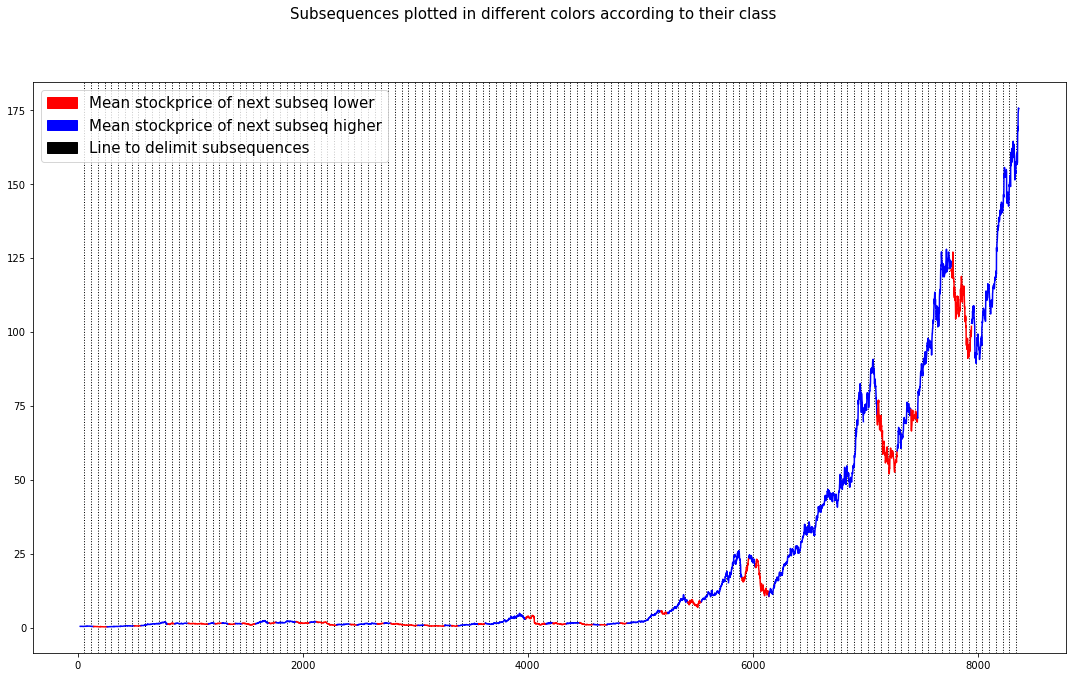

In [169]:
# plot all subsequence in one figure
for i, sample in enumerate(lst_of_subsequences):
    plt.axvline(60*(i+1), color='k', linestyle='dotted', linewidth=1)
    if lst_of_labelled_data[i-1] == 1:
        plt.plot(sample,"b")
    else:
       plt.plot(sample,"r")

fig = matplotlib.pyplot.gcf()
fig.suptitle('Subsequences plotted in different colors according to their class', fontsize=15)
fig.set_size_inches(18.5, 10.5)
red_patch = mpatches.Patch(color='red', label='Mean stockprice of next subseq lower')
blue_patch = mpatches.Patch(color='blue', label='Mean stockprice of next subseq higher')
black_patch = mpatches.Patch(color='black', label='Line to delimit subsequences')
plt.legend(handles=[red_patch, blue_patch, black_patch], prop={"size":15})
plt.show()

Obviously this is not a proof or a correct way to test software, but since this is a Notebook and not an application, I consider this way as sufficient. 

Now we have some tools for feature engineering. We can split a whole time-series into subsequences
<br> 
and we can label these subsequences.
<br> 
Note: these subsequences are still time-series data. 

Let's have a look:

In [170]:
# we only want to use the 'High' of the stock data per day
ser = df['High']

# init a DataPreProcessor object for getting our labeled data
# our subseq_len is 45 that means "45 days future prediciton"
DPP = DataPreProcessor(ser, subseq_len=45)

# X are our subsequences and y is our target array:
# get_train_test_split() shuffles the data for more generalization
X_train, X_test, y_train, y_test = DPP.get_train_test_split()

Let's have a look at our target array.
<br>
Remeber: We have two classes:

Class 0: The mean share price (stock price) of the next chronological subsequence will decrease compared to the given subsequence.
<br>
Class 1: The mean share price (stock price) of the next chronological subsequence will decrease compared to the given subsequence.


NOTE: In our y_train array we shuffled the data. So there is no chronological order!

In [171]:
print(y_train)

[1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0
 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0
 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 0]


We should check if our data is balanced:

In [172]:
print("Percentage of labelcode 1 in our dataset \n", np.count_nonzero(y_train)/len(y_train))

# --> our data is unbalanced

Percentage of labelcode 1 in our dataset 
 0.6341463414634146


Let's see how our data looks like! We will use a simple plot to visualize the data.
<br>
Remember that we got rid of the dates so we can only visualize the index.
<br>
As we can see from the target array 

You can see that the data is shuffled, since the index of the samples is not continous.

Text(0.5, 1.0, 'Subsequence with Label 0')

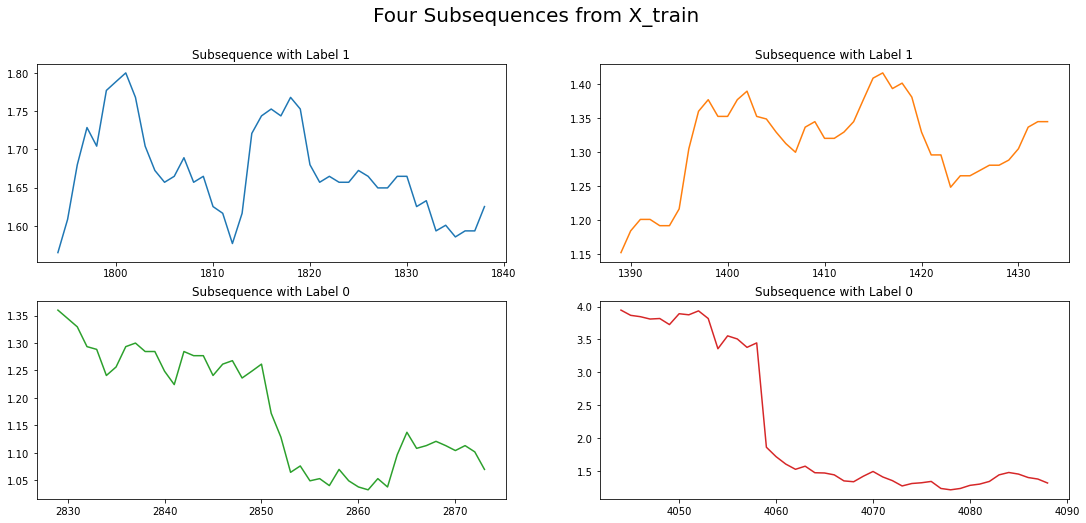

In [173]:
#get idx for subsequences with label 1 and label 2
idx_label_1 = [i for i in range(len(y_train)) if y_train[i]==1]
idx_label_0 = [i for i in range(len(y_train)) if y_train[i]==0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(18.5, 8)
fig.suptitle('Four Subsequences from X_train', fontsize=20)
ax1.plot(X_train[idx_label_1[0]])
ax1.set_title('Subsequence with Label 1')
ax2.plot(X_train[idx_label_1[1]], 'tab:orange')
ax2.set_title('Subsequence with Label 1')
ax3.plot(X_train[idx_label_0[0]], 'tab:green')
ax3.set_title('Subsequence with Label 0')
ax4.plot(X_train[idx_label_0[1]], 'tab:red')
ax4.set_title('Subsequence with Label 0')

For a financial greenhorn like me it is hard to interprete these plots but maybe the algorithm can find some pattern.

## 2.2 Feature Extraction

Now that we have our data structured in labeled subsequences we can run our Greedy Shapelet Search algorithm. 

The algorithm searches for shapelets that are most representive of a class.
<br>
With the distance of the shapelet and the 
In the next cell I will explain a bit more about the algorithm. Note, that the algorithm used here is not exactly the same as described below. It is a variation of this basic algorithm.

<a id='anchor_feature_extraction'></a>
If you are not interested in how the GreedyShapelet algorithm finds the best shapelet, you can skip this part!

The simplest implementation of this algorithm is abrute force implementation:  

1. Generate all possible shapelet candidates:
<br>
Candidates can be found by sliding a window of size l across all of the subsequences in X_train our data into subsequences. Sice l can vary from the shapelet_min_size to the shapelet_max_size. These candidates are saved in the candidate pool.

2. Check how well a candidate can seperate our data into class 0 or class 1.
<br>
This is done by checking for every candidate and every subsequence in x_train the minimal distance of the subsequence and the candidate:
<br>
    Since we can only calculate the distance of time-series with the same length, a sliding window approach is used here. The distance of the candidate and a window of the subsequence can be found by calculating the euclidean distance (or more sophisticated time-series distances) of the candidate and the subsequence. Intuitively, this distance is simply the distance between the candidate and its best matching location of the given subsequence.
<br>
Now we have all the minimal distances from our candidate to our subsequences of x_train. We will use our label 
array to find an optimal splitting point. This splitting point is simply a distance treshold dividing our
two classes.

3. Now the information gain of every candidate can be calculated:
<br>
    The information gain explains how well the given splitting point can seperate our dataset x_train into
    class 0 and 1.

4. The candidate with the best information gain is choosen as our shapelet.

5. Knowing the best n shaplets we can use the min distances of the shapelet and the subsequences of our dataset as n dimensional features.

For more information check: 
Ye, L., Keogh, E. Time series shapelets: a novel technique that allows accurate, interpretable and fast classification. Data Min Knowl Disc 22, 149–182 (2011). https://doi.org/10.1007/s10618-010-0179-5


In [174]:
# The algorithm needs numpy arrays as input:

X_train = np.array(X_train)
X_test = np.array(X_test)

# init new GSS object
GSS = GreedyShapeletSearch()

We can use the function `get_top_k_shapelets` from the object GSS, to calculate the top shapelets and save them as an attribute (`top_shapelets`) of GSS.

n_shapelets:
<br>
For this we should decide on the number of top shapelets we want to use. This will have an linear impact on our dimension of our feature array.
Every shapelet adds a feature column to our feature array. I tried different approaches for number of shapelets and min/max size of shapelets. 
The number 3 seems to be a good balance between runtime and results. 

shapelet_min_size & shapelet_max_size:
<br>
From previous tries I could see that shapelets with a size smaller than 15 have a smaller information gain, than those between 15 and 25.
That is the reason for shapelet_min_size=15 and shapelet_max_size=25

Note:
<br>
Since we have one data point for one day the shapelet_size corresponse to the days the shapelet is representing. With a shapelet_min_size of 15 we try to avoid daily fluctuations. 






In [175]:
 # calculate top shapelets
 # we will start with the top 3 shapelets -> that means we will have a 3 dimensional feature array
 # shapelet min size is set to 15 (15 days) 
GSS.get_top_k_shapelets(
    X_train = X_train, 
    y_train = y_train, 
    n_shapelets = 3,
    shapelet_min_size = 15,
    shapelet_max_size = 25
)

Searching for shapelet 1...


100%|██████████| 10/10 [02:02<00:00, 12.26s/it]


Found shapelet 1 at sample: 4, candidate: 2.
Searching for shapelet 2...


100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


Found shapelet 2 at sample: 46, candidate: 5.
Searching for shapelet 3...


100%|██████████| 10/10 [01:56<00:00, 11.63s/it]

Found shapelet 3 at sample: 62, candidate: 11.


In [176]:
len(GSS.top_shapelets)

3

Text(0.5, 1.0, 'Top Shapelet No. 3')

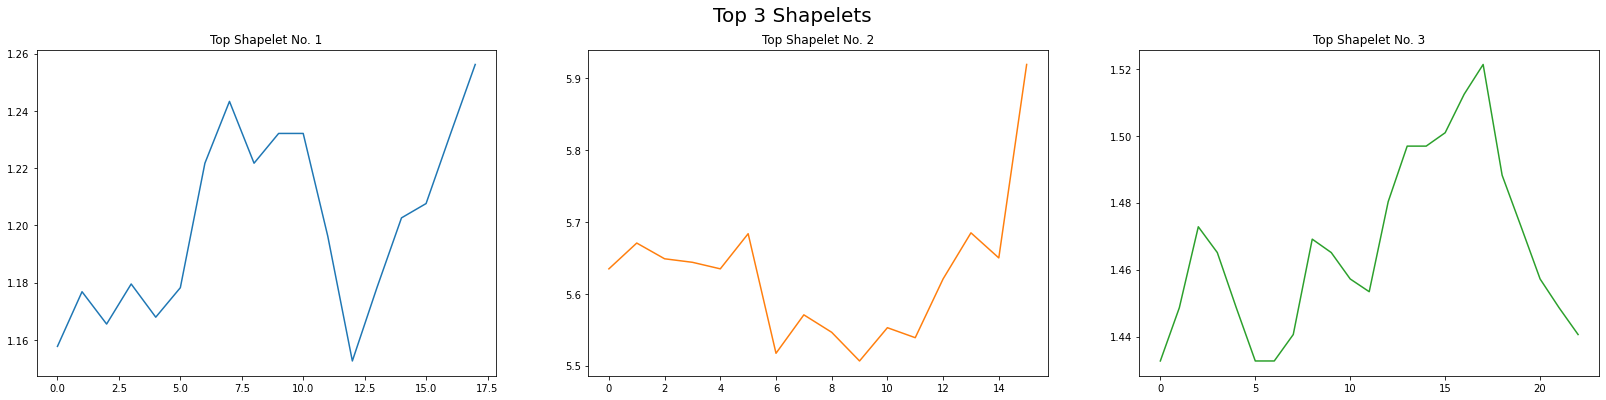

In [177]:
#Let's see how our top shapelets look like

top_shapelets = GSS.top_shapelets


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(28, 6)
fig.suptitle('Top 3 Shapelets', fontsize=20)
ax1.plot(top_shapelets[0][5])
ax1.set_title('Top Shapelet No. 1')
ax2.plot(top_shapelets[1][5], 'tab:orange')
ax2.set_title('Top Shapelet No. 2')
ax3.plot(top_shapelets[2][5], 'tab:green')
ax3.set_title('Top Shapelet No. 3')

Now we have extracted low dimensional features from our time-series. These shapelets are instances of our GSS object. Let's see how our new features look like.

In [178]:
# featurs transform returns our min distance of every shapelet to every element in x_train
Z_train = features_transform(X_train, GSS)

Z_test = features_transform(X_test, GSS)

# Let's see how the data looks like:
print("Z_train: \n", Z_train[0:5])
print("Z_test: \n", Z_test[0:5])

Z_train: 
 [[3.71409489 3.31637694 4.7624045 ]
 [5.21740966 3.8061778  6.50590516]
 [3.78051094 2.91170568 3.53191136]
 [5.83943446 3.14928034 7.69292869]
 [0.         3.62728563 5.28620274]]
Z_test: 
 [[3.35994589 3.05091393 2.42362525]
 [3.79311821 2.80268279 3.72595005]
 [2.60076935 3.53299308 3.76056678]
 [3.3857037  2.81111471 3.76293593]
 [4.61622899 2.52763276 6.68245748]]


In [179]:
###########################
# Training set
###########################

# we will use z-score/ Z Standardisation since the raw distances can have an impact on our classifier.
normalization_mean = Z_train.mean(axis=0)
normalization_std = Z_train.std(axis=0)

Z_standardized = (Z_train - normalization_mean) / normalization_std        # for our baseline models
scaler = sk.preprocessing.MinMaxScaler(feature_range=(0,1))  # for our NNs

Z_minMaxScaler = scaler.fit_transform(Z_train)

# let's see the head of the data again
print("Using Standardization Z_standardized \n", Z_standardized[0:5])
print("Using Min-Max-Scaler Z_minMaxScaler \n", Z_minMaxScaler[0:5])

# convert to pandas dataframe for easy handling
df_Z_std = pd.DataFrame(Z_standardized, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3"])
df_Z_minMax = pd.DataFrame(Z_minMaxScaler, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3"])
#df_Z_std = pd.DataFrame(Z_standardized, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3", "Dist_Shapelet_4", "Dist_Shapelet_5"])
#df_Z_minMax = pd.DataFrame(Z_minMaxScaler, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3", "Dist_Shapelet_4", "Dist_Shapelet_5"])


###########################
# Test set
###########################

# we will use z-score/ Z Standardisation since the raw distances can have an impact on our classifier.
normalization_mean = Z_test.mean(axis=0)
normalization_std = Z_test.std(axis=0)

Z_test_standardized = (Z_test - normalization_mean) / normalization_std        # for our baseline models
Z_test_minMaxScaler = scaler.fit_transform(Z_test)

# let's see the head of the data again
print("Using Standardization (Z_test_standardized) \n", Z_test_standardized[0:5])
print("Using Min-Max-Scaler (Z_test_minMaxScaler) \n", Z_test_minMaxScaler[0:5])

# convert to pandas dataframe for easy handling
df_Z_test_std = pd.DataFrame(Z_test_standardized, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3"])
df_Z_test_minMax = pd.DataFrame(Z_test_minMaxScaler, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3"])

#df_Z_test_std = pd.DataFrame(Z_test_standardized, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3", "Dist_Shapelet_4", "Dist_Shapelet_5"])
#df_Z_test_minMax = pd.DataFrame(Z_test_minMaxScaler, columns=["Dist_Shapelet_1","Dist_Shapelet_2","Dist_Shapelet_3", "Dist_Shapelet_4", "Dist_Shapelet_5"])


Using Standardization Z_standardized 
 [[-0.18122974 -0.04859485  0.14259389]
 [ 1.40902539  0.60187719  1.56298889]
 [-0.11097268 -0.58601192 -0.85986418]
 [ 2.06702339 -0.27050477  2.53003314]
 [-4.11011975  0.36430236  0.56932181]]
Using Min-Max-Scaler Z_minMaxScaler 
 [[0.56514432 0.59189022 0.6190626 ]
 [0.7938918  0.6793074  0.8456994 ]
 [0.57525033 0.51966653 0.4591114 ]
 [0.88854037 0.56206766 1.        ]
 [0.         0.64737963 0.68715088]]
Using Standardization (Z_test_standardized) 
 [[-0.48713884 -0.34045753 -1.68602881]
 [ 0.06901327 -0.67883982 -0.56829371]
 [-1.46184941  0.31670033 -0.5385835 ]
 [-0.45406826 -0.66734564 -0.53655016]
 [ 1.12580933 -1.05378091  1.96916249]]
Using Min-Max-Scaler (Z_test_minMaxScaler) 
 [[0.28141383 0.36992523 0.06269002]
 [0.4018848  0.31348541 0.32640294]
 [0.07027676 0.47953461 0.33341262]
 [0.28857742 0.31540256 0.33389236]
 [0.63080282 0.25094783 0.92507786]]


In [180]:
# again let's have a look into the DataFrames:
df_Z_std.head()

,Dist_Shapelet_1,Dist_Shapelet_2,Dist_Shapelet_3
0,-0.181230,-0.048595,0.142594
1,1.409025,0.601877,1.562989
2,-0.110973,-0.586012,-0.859864
3,2.067023,-0.270505,2.530033
4,-4.110120,0.364302,0.569322


In [181]:
df_Z_minMax.head()

,Dist_Shapelet_1,Dist_Shapelet_2,Dist_Shapelet_3
0,0.565144,0.591890,0.619063
1,0.793892,0.679307,0.845699
2,0.575250,0.519667,0.459111
3,0.888540,0.562068,1.000000
4,0.000000,0.647380,0.687151


We can also have a look at the correlation matrix:

In [240]:
corr = df_Z_std.corr()

corr.style.background_gradient(cmap='coolwarm')

,Dist_Shapelet_1,Dist_Shapelet_2,Dist_Shapelet_3
Dist_Shapelet_1,1.000000,0.359584,0.501403
Dist_Shapelet_2,0.359584,1.000000,0.373941
Dist_Shapelet_3,0.501403,0.373941,1.000000


This shows that there are correlations but not too strong. That means our shapelets are not similar. A correlation of 1 would mean we have two exact same shapelets. We would have recognized that correlation before, since we plotted the shapelets. 

# 3. Testing Phase I: Baseline Models

Now that all the hard work is done we can start with our Machine Learning models to tackle the classification problem.

Scoring function:


What is our goal?
<br>
We need to decide for a scoring function. For that it is important to recap that we want to know if the mean share price
for our next sequence (here 60 days) is higher or lower than the price of the previous sequence. We could use this information 
for investing in the stock market. If we think the share price is increasing we could bet on increasing share prices with a long position (https://en.wikipedia.org/wiki/Long_(finance)) 
otherwise we could bet against that stock what is called a short position (https://en.wikipedia.org/wiki/Short_(finance)). 
<br>
What does that mean for our scoring function?
<br>
We can assume that false positive and false negative are equally bad for us. Thus we need a score trying to explain exactly this. 

Imbalanced Data:
<br>
We have seen that our data is imbalanced --> we need to take that into account. 

Recall and Precision:
<br>
Recall and Precision are mostly used when the classes are inequally important. Here both classes are equivalent important.

Accuracy:
<br>
Accuracy just counts how often we are right. No need for weigthing a class or something else.
Thus we will choose the accuracy for tuning our models. Anyways it is always good to have a look into various scores.



 


NOTE:
<br>
I won't use dimensionality reduction, since we have already performed a dimensionality reduction by choosing the top 3 shapelets. 
Remember, that the shapelets where sorted for their information gain on the training data. 

In [183]:
# we will need to implement a routine since we want to test several models:

# k-fold cross validation for more generalization on the model performance

def k_fold_split_training(X_train, y_train, model):
    '''
    Train the given model on a 5-fold crossvalidation and prints the results while computing.

    Params:
    -------
    X_train : pd DataFrame
        Trainingset
    y_train : np array
        Target array
    model : object of sk-learn classification model
        Classification model (clf)

    Returns
    -------
    training_scores : List
        List of all 5 training scores (balanced accuracy)
    cv_scores : List 
        List of all 5 validation scores (balanced accuracy)
    '''
    k_fold = sk.model_selection.StratifiedKFold(n_splits=5)
    cv_scores = list()
    training_scores= list()

    #generating indices for the k-fold split to select training and test data:
    for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train):

        X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
        y_train_fold, y_cv_fold = y_train[train_index], y_train[cv_index]

        #Fitting the model to the data:
        model.fit(X_train_fold, y_train_fold)
        
        y_hat_train = model.predict(X_train_fold)
        y_hat_validation = model.predict(X_cv_fold)

        #getting scores from Training data:
        scoreTraining = sk.metrics.accuracy_score(y_train_fold, y_hat_train,)
        training_scores.append(scoreTraining)

        #getting scores from k-fold test data:
        scoreCV = sk.metrics.accuracy_score(y_cv_fold, y_hat_validation,)
        cv_scores.append(scoreCV)
    
        #printing the results:
        print('Training Score: ', scoreTraining)
        print('CV Score: ', scoreCV)
    return training_scores, cv_scores

## 3.1 Support Vector Classifier

See:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [305]:
svc_linear = sk.svm.SVC(
    kernel = 'linear',
    class_weight = 'balanced',
    tol = 0.0001,
    random_state = 2022
    )

svc_training_scores, svc_cv_scores = k_fold_split_training(df_Z_std, y_train, svc_linear)

# get the mean values
svc_mean_training_score = sum(svc_training_scores)/len(svc_training_scores)
svc_mean_cv_score = sum(svc_cv_scores)/len(svc_cv_scores)

print("svc_mean_training_score \n", svc_mean_training_score)
print("svc_mean_cv_score \n", svc_mean_cv_score)


Training Score:  0.8072916666666667
CV Score:  0.8452380952380952
Training Score:  0.8072916666666667
CV Score:  0.7867647058823529
Training Score:  0.8142857142857143
CV Score:  0.7017543859649122
Training Score:  0.8369565217391304
CV Score:  0.7412587412587412
Training Score:  0.7830316742081449
CV Score:  0.9411764705882353
svc_mean_training_score 
 0.8097714487132647
svc_mean_cv_score 
 0.8032384797864675


In [309]:
# Let's try it on our test data

# train again on the whole train dataset 
svc_linear.fit(df_Z_std, y_train)

y_hat_svc = svc_linear.predict(df_Z_test_std)
test_score_svc = sk.metrics.accuracy_score(y_hat_svc, y_test)

print("Test Score SVC with linear kernel \n", test_score_svc)

Test Score SVC with linear kernel 
 0.7049180327868853


We will try some different kernels before we try different models:

In [307]:
svc_rbf = sk.svm.SVC(
    kernel = 'rbf',
    class_weight = 'balanced',
    tol = 0.0001,
    random_state = 2022
    )

svc_training_scores, svc_cv_scores = k_fold_split_training(df_Z_std, y_train, svc_rbf)

# get the mean values
svc_mean_training_score = sum(svc_training_scores)/len(svc_training_scores)
svc_mean_cv_score = sum(svc_cv_scores)/len(svc_cv_scores)

print("svc_mean_training_score \n", svc_mean_training_score)
print("svc_mean_cv_score \n", svc_mean_cv_score)

Training Score:  0.8211362542128069
CV Score:  0.8263888888888888
Training Score:  0.8117647058823529
CV Score:  0.7395833333333333
Training Score:  0.856225077536553
CV Score:  0.746031746031746
Training Score:  0.8595982142857144
CV Score:  0.6928571428571428
Training Score:  0.8130434782608695
CV Score:  0.875
svc_mean_training_score 
 0.8323535460356594
svc_mean_cv_score 
 0.7759722222222223


In [308]:
# Let's try it on our test data

# train again on the whole train dataset 
svc_rbf.fit(df_Z_std, y_train)

y_hat_svc = svc_rbf.predict(df_Z_test_std)
test_score_svc = sk.metrics.accuracy_score(y_hat_svc, y_test)

print("Test Score SVC with rbf\n", test_score_svc)

Test Score SVC with rbf
 0.6885245901639344


It seems that the linear kernel performs better

## 3.2 Random Forest Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [186]:
# hyperparameter are default values from scikit-learn
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=2022
)

rf_training_scores, rf_cv_scores = k_fold_split_training(df_Z_std, y_train, rf)

# get the mean values
rf_mean_training_score = sum(rf_training_scores)/len(rf_training_scores)
rf_mean_cv_score = sum(rf_cv_scores)/len(rf_cv_scores)

print("rf_mean_training_score \n", rf_mean_training_score)
print("rf_mean_cv_score \n", rf_mean_cv_score)


Training Score:  1.0
CV Score:  0.8786764705882353
Training Score:  1.0
CV Score:  0.7867647058823529
Training Score:  1.0
CV Score:  0.6499999999999999
Training Score:  1.0
CV Score:  0.78125
Training Score:  1.0
CV Score:  0.8222222222222222
rf_mean_training_score 
 1.0
rf_mean_cv_score 
 0.7837826797385621


In [187]:
# Let's try it on our test data

# train again on the whole train dataset 
rf.fit(df_Z_std, y_train)

y_hat_rf = rf.predict(df_Z_test_std)
test_score_rf = sk.metrics.accuracy_score(y_test, y_hat_rf,)

print("Test Score Random Forest \n", test_score_rf)

Test Score Random Forest 
 0.7156177156177156


As you can see the from the training scores, our model is overfitting. That is no suprise at all, since our dataset is pretty small. Anyways the results are promising. We will try some hyperparameter tuning to reduce overfitting.

Before that we can have a look at the importance of every feature for our model:

In [188]:
feature_names= ("Importance of Distance to Shapelet 1", "Importance of Distance to Shapelet 2", "Importance of Distance to Shapelet 3")

pred_comp = rf.fit(df_Z_std, y_train)
for name, score in zip(feature_names, pred_comp.feature_importances_):
    print(name, ": ", score)

Importance of Distance to Shapelet 1 :  0.44791650759044777
Importance of Distance to Shapelet 2 :  0.2553784839576358
Importance of Distance to Shapelet 3 :  0.2967050084519166


This is surprising, since we sorted the shapelets w.r.t. their information gain (see chapter 4.2 Feature Extraction). I was expecting the Shapelet 1 to be the most important feature. This shows that we should go for more shapelets. The problem is that a higher number of shapelets is  

### 3.2.1 Random Forest Classifier - Hyperparameter tuning

We will use a grid search to optimize choosen parameter. Since the grid search is highly time consuming, we will decide on three hyperparameter to run the grid search.

A possible solution to reduce overfitting of our model is to prune the depth of the trees and the number of trees in the forest.



In [189]:
# let's have a look at the default values for the hyperparams:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

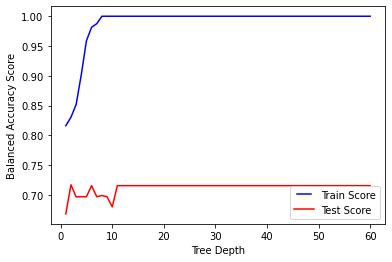

In [190]:
# inspired by https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d


max_depths = np.linspace(1, 60, 60, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = sk.ensemble.RandomForestClassifier(max_depth=max_depth, random_state=2022)
   rf.fit(df_Z_std, y_train)
   train_pred = rf.predict(df_Z_std)
   train_score = sk.metrics.accuracy_score(y_train, train_pred)
   train_results.append(train_score)

   test_pred = rf.predict(df_Z_test_std)
   test_score = sk.metrics.accuracy_score(y_test, test_pred)
   test_results.append(test_score)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train Score')
line2, = plt.plot(max_depths, test_results, 'r', label='Test Score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Balanced Accuracy Score')
plt.xlabel('Tree Depth')
plt.show()

The plot shows that we could decide on a value between max depth of 5 to 8 (we will check the exact value) to reduce overfitting and have a better test score. 

In [191]:
# we are printing the index+1 since the max depth startet with 1 and idx of list starts with 0
print("Best Test Score ({1}) is at Tree Depth : {0}".format(np.argmax(test_results)+1, test_results[np.argmax(test_results)] ))
print("Best Train Score ({1}) is at Tree Depth : {0}".format(np.argmax(train_results)+1, train_results[np.argmax(train_results)]))

#save it
best_max_depth = np.argmax(test_results)+1

Best Test Score (0.7170542635658914) is at Tree Depth : 2
Best Train Score (1.0) is at Tree Depth : 8


I tried this several times with different shapelets sometimes you can see a peak for the test score at around Tree Depth of 2 to 8. Here the best tree depth is saved also it could be a lucky shot. 

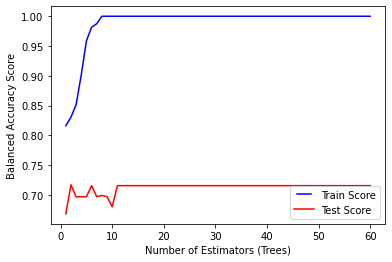

In [316]:
n_estimators = np.linspace(1, 150, 60, endpoint=True, dtype=int)
train_results_estimators = []
test_results_estimators = []

for n_estimator in n_estimators:
   rf = sk.ensemble.RandomForestClassifier(n_estimators=n_estimator)
   rf.fit(df_Z_std, y_train)
   train_pred = rf.predict(df_Z_std)
   train_score = sk.metrics.accuracy_score(y_train, train_pred)
   train_results_estimators.append(train_score)

 
   test_pred = rf.predict(df_Z_test_std)
   test_score = sk.metrics.accuracy_score(y_test, test_pred)
   test_results_estimators.append(test_score)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train Score', markevery=[5])
line2, = plt.plot(max_depths, test_results, 'r', label='Test Score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Balanced Accuracy Score')
plt.xlabel('Number of Estimators (Trees)')
plt.show()

In [193]:
# we are printing the index+1 since the max depth startet with 1 and idx of list starts with 0
print("Best Test Score ({1}) is for n_estimators (number of trees) : {0}".format(np.argmax(test_results_estimators)+1, test_results_estimators[np.argmax(test_results_estimators)] ))
print("Best Train Score ({1}) is for n_estimators (number of trees) : {0}".format(np.argmax(train_results_estimators)+1, train_results_estimators[np.argmax(train_results_estimators)]))

#save it
best_n_estimators = np.argmax(test_results_estimators)+1

Best Test Score (0.7333333333333334) is for n_estimators (number of trees) : 32
Best Train Score (1.0) is for n_estimators (number of trees) : 8


# 4. Testing Phase II: Neuronal Network

Now we need our scaled data. Remember we use standardization (df_Z_std) and MinMax scaler (df_Z_MinMax)

In [194]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import keras as ks
from tensorflow.keras import Sequential

In [278]:
loss_function = 'BinaryCrossentropy'
activation_function = 'relu'        # ReLu most common for MLPs
last_layer_activation_function = 'sigmoid'  # most common for binary classification 
optimizer = 'Adam'
kernel_initializer = ks.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  # init of our weights is random 
num_epochs = 200
batch_size = 10

We will start with a simple model and see how it performs. The parameter choosen above are kind of arbitray. Of course there are recommendation on how to build a DL model for classification and on what activation function to choose etc.. But in my opinion there is no True and False and often combinations work that are not expected. Thus sometimes it's better to try different approaches than to think of the best combination of parameters for hours. 

In [241]:
model = Sequential()
model.add(Dense(df_Z_minMax.shape[1], activation= activation_function, kernel_initializer=kernel_initializer))
model.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer, ))
model.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer))
model.add(Dense(1 ,activation = last_layer_activation_function, kernel_initializer=kernel_initializer))
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

What did I try here?
<br>
I changed every parameter one by one with the assumption that the parameters are independent.

- changed size of dense layers [3, 6, 9, 21, 30] --> no big impact +/- 2% accuracy (sizes of 3 to 9 with better results)
- changed activation function [relu, sigmoid]
- last_layer_activation_function [softmax, sigmoid]
- optimizer [SGD, Adam]

In [237]:
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 3)                 12        
                                                                 
 dense_62 (Dense)            (None, 3)                 12        
                                                                 
 dense_63 (Dense)            (None, 6)                 24        
                                                                 
 dense_64 (Dense)            (None, 1)                 7         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [335]:
history = model.fit(df_Z_minMax, y_train, batch_size=8, epochs=num_epochs, verbose=1, validation_split=0.2)

Epoch 1/200
13/13 [==============================] - 0s 16ms/step - loss: 0.6580 - accuracy: 0.6327 - val_loss: 0.6540 - val_accuracy: 0.6400
Epoch 2/200
13/13 [==============================] - 0s 8ms/step - loss: 0.6594 - accuracy: 0.6327 - val_loss: 0.6540 - val_accuracy: 0.6400
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 0.6585 - accuracy: 0.6327 - val_loss: 0.6539 - val_accuracy: 0.6400
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.6575 - accuracy: 0.6327 - val_loss: 0.6539 - val_accuracy: 0.6400
Epoch 5/200
13/13 [==============================] - 0s 5ms/step - loss: 0.6588 - accuracy: 0.6327 - val_loss: 0.6538 - val_accuracy: 0.6400
Epoch 6/200
13/13 [==============================] - 0s 5ms/step - loss: 0.6578 - accuracy: 0.6327 - val_loss: 0.6538 - val_accuracy: 0.6400
Epoch 7/200
13/13 [==============================] - 0s 6ms/step - loss: 0.6579 - accuracy: 0.6327 - val_loss: 0.6538 - val_accuracy: 0.6400
Epoch 8/200


In [245]:
evaluation = model.evaluate(df_Z_test_minMax, y_test, verbose=1, return_dict=True)

print(evaluation.keys())

print("Test Loss:", evaluation['loss'])
print("Test Accuracy:", evaluation['accuracy'])

2/2 [==============================] - 0s 8ms/step - loss: 0.6529 - accuracy: 0.6393
dict_keys(['loss', 'accuracy'])
Test Loss: 0.6528770327568054
Test Accuracy: 0.6393442749977112


In [269]:
# inspired by lecture 9, DDE1, Dr. Ates
def plot_learning_curves(history):
    #We will omit the first 10 points for a better visualization:
    plt.plot(history['epoch'][10:],history['loss'][10:], "k--", linewidth=1.5, label="Training")
    plt.plot(history['epoch'][10:],history['val_loss'][10:], "b-.", linewidth=1.5, label="CV test")
    plt.legend()
    plt.yscale("log")
    plt.xlabel("Epochs"),  plt.ylabel("Binary Crossentropy")

In [271]:
hist = pd.DataFrame(history.history)
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy
244,0.657496,0.632653,0.653518,0.64
214,0.658162,0.632653,0.653421,0.64
92,0.657509,0.632653,0.653528,0.64


In [272]:
#Adding epoch column:
hist['epoch'] = history.epoch
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
258,0.657951,0.632653,0.653600,0.64,258
201,0.657609,0.632653,0.653441,0.64,201
88,0.657608,0.632653,0.653588,0.64,88


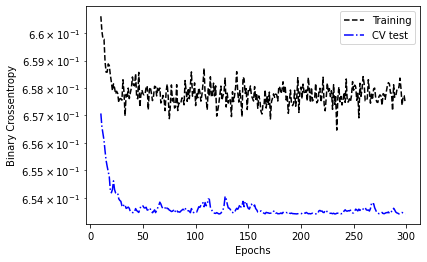

In [273]:
plot_learning_curves(hist)

- You can see that the NN is probably underfitted (train acc of 0.63 and test acc of 0.63).
- We can try to add some more layers. Dropouts seems to have no impact here. We can try it anyways.
- More epochs seem to have no impact since the NN quickly converge --> remember our dataset is pretty small

Quoted from keras:
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting

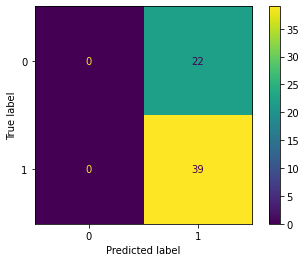

In [336]:
#Let's have a look into the prediction I assume that we only predict class 1:

y_pred = model.predict(df_Z_test_minMax)

sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

That is what I expected. The NN is not capable of predicting class 0. 

I could not found an error in my code or my input data so I assume that the samples of class 0 are too less to make an impact on our NN. 
Nevertheless we will try to optimize it. I don't think more complex NN will perform better but we can try.

# 5 Testing Phase III: Model Regularization and Hyperparameter optimization

Here we will try to optimize our NN so that it can predict both classes. 

What we will do:
- Try out more layers --> make NN more complex
- Add Dropouts

Let's build a new model:

In [274]:
model_2 = Sequential()
model_2.add(Dense(df_Z_minMax.shape[1], activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(df_Z_minMax.shape[1],)))
model_2.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(df_Z_minMax.shape[1],)))
model_2.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(df_Z_minMax.shape[1],)))
model_2.add(Dense(9, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dense(9, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dropout(0.2))
model_2.add(Dense(9, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dense(9, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dense(9, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dropout(0.2))
model_2.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(9,)))
model_2.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(3,)))
model_2.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(3,)))
model_2.add(Dense(1 ,activation = "softmax", kernel_initializer=kernel_initializer))
model_2.compile(optimizer="Adam", loss=loss_function, metrics=['accuracy'])

In [282]:
print(model_2.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 3)                 12        
                                                                 
 dense_158 (Dense)           (None, 3)                 12        
                                                                 
 dense_159 (Dense)           (None, 6)                 24        
                                                                 
 dense_160 (Dense)           (None, 6)                 42        
                                                                 
 dense_161 (Dense)           (None, 9)                 63        
                                                                 
 dense_162 (Dense)           (None, 9)                 90        
                                                                 
 dropout_8 (Dropout)         (None, 9)               

Now we have quite a lot (not comparable to Deep Learning) trainable params

In [275]:
history_2 = model_2.fit(df_Z_minMax, y_train, batch_size=8, epochs=num_epochs, verbose=1, validation_split=0.2)

Epoch 1/300
13/13 [==============================] - 4s 176ms/step - loss: 0.6841 - accuracy: 0.6327 - val_loss: 0.6811 - val_accuracy: 0.6400
Epoch 2/300
13/13 [==============================] - 0s 6ms/step - loss: 0.6810 - accuracy: 0.6327 - val_loss: 0.6758 - val_accuracy: 0.6400
Epoch 3/300
13/13 [==============================] - 0s 8ms/step - loss: 0.6755 - accuracy: 0.6327 - val_loss: 0.6721 - val_accuracy: 0.6400
Epoch 4/300
13/13 [==============================] - 0s 9ms/step - loss: 0.6715 - accuracy: 0.6327 - val_loss: 0.6693 - val_accuracy: 0.6400
Epoch 5/300
13/13 [==============================] - 0s 13ms/step - loss: 0.6700 - accuracy: 0.6327 - val_loss: 0.6661 - val_accuracy: 0.6400
Epoch 6/300
13/13 [==============================] - 0s 16ms/step - loss: 0.6677 - accuracy: 0.6327 - val_loss: 0.6635 - val_accuracy: 0.6400
Epoch 7/300
13/13 [==============================] - 0s 16ms/step - loss: 0.6649 - accuracy: 0.6327 - val_loss: 0.6622 - val_accuracy: 0.6400
Epoch 8/

In [281]:
evaluation_2 = model_2.evaluate(df_Z_test_minMax, y_test, verbose=1, return_dict=True)

print(evaluation_2.keys())

print("Test Loss:", evaluation_2['loss'])
print("Test Accuracy:", evaluation_2['accuracy'])

2/2 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6393
dict_keys(['loss', 'accuracy'])
Test Loss: 0.6538830399513245
Test Accuracy: 0.6393442749977112


Same issue: cannot predict class 0

In [289]:
hist_2 = pd.DataFrame(history.history)
hist_2['epoch'] = history.epoch
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
46,0.658567,0.632653,0.653471,0.64,46
139,0.658594,0.632653,0.653622,0.64,139
85,0.657407,0.632653,0.653481,0.64,85


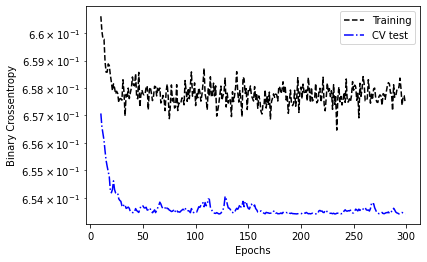

In [290]:
plot_learning_curves(hist_2)

Our NN does not perform well and converge pretty quickly. Probably since we do not have a lot of data. NN usually perform well on larger data sets. Anyways we will try to add more neurons.

### Adding more Neurons

In [294]:
model_3 = Sequential()
model_3.add(Dense(df_Z_minMax.shape[1], activation= activation_function, kernel_initializer=kernel_initializer, input_shape=(df_Z_minMax.shape[1],)))
model_3.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dropout(0.4))
model_3.add(Dense(12, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(24, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dropout(0.3))
model_3.add(Dense(48, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(48, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dropout(0.4))
model_3.add(Dense(24, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dropout(0.3))
model_3.add(Dense(12, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dropout(0.4))
model_3.add(Dense(6, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(3, activation= activation_function, kernel_initializer=kernel_initializer))
model_3.add(Dense(1 ,activation = "softmax", kernel_initializer=kernel_initializer))
model_3.compile(optimizer="Adam", loss=loss_function, metrics=['accuracy'])

In [295]:
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 3)                 12        
                                                                 
 dense_132 (Dense)           (None, 3)                 12        
                                                                 
 dense_133 (Dense)           (None, 6)                 24        
                                                                 
 dense_134 (Dense)           (None, 6)                 42        
                                                                 
 dense_135 (Dense)           (None, 9)                 63        
                                                                 
 dense_136 (Dense)           (None, 9)                 90        
                                                                 
 dropout_4 (Dropout)         (None, 9)               

#### Early Stopping
Here we will use early stopping.

Quote from keras:
Stop training when a monitored metric has stopped improving.

In [298]:
Early_stopping = ks.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [299]:
history_3 = model_3.fit(df_Z_minMax, y_train, batch_size=8, epochs=num_epochs, verbose=1, validation_split=0.2, callbacks=Early_stopping)

Epoch 1/200
13/13 [==============================] - 0s 15ms/step - loss: 0.6568 - accuracy: 0.6327 - val_loss: 0.6542 - val_accuracy: 0.6400
Epoch 2/200
13/13 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6327 - val_loss: 0.6541 - val_accuracy: 0.6400
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6542 - accuracy: 0.6327 - val_loss: 0.6542 - val_accuracy: 0.6400
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6618 - accuracy: 0.6327 - val_loss: 0.6540 - val_accuracy: 0.6400
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 0.6614 - accuracy: 0.6327 - val_loss: 0.6539 - val_accuracy: 0.6400
Epoch 6/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6561 - accuracy: 0.6327 - val_loss: 0.6537 - val_accuracy: 0.6400
Epoch 7/200
13/13 [==============================] - 0s 9ms/step - loss: 0.6585 - accuracy: 0.6327 - val_loss: 0.6536 - val_accuracy: 0.6400
Epoch 8/2

In [280]:
evaluation_3 = model_3.evaluate(df_Z_test_minMax, y_test, verbose=1, return_dict=True)

print(evaluation_3.keys())

print("Test Loss:", evaluation_3['loss'])
print("Test Accuracy:", evaluation_3['accuracy'])

2/2 [==============================] - 0s 6ms/step - loss: 0.6539 - accuracy: 0.6393
dict_keys(['loss', 'accuracy'])
Test Loss: 0.6538650393486023
Test Accuracy: 0.6393442749977112


Same issue: cannot predict class 0

In [291]:
hist_3 = pd.DataFrame(history.history)
hist_3['epoch'] = history.epoch
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
294,0.658359,0.632653,0.653430,0.64,294
84,0.657452,0.632653,0.653494,0.64,84
187,0.657686,0.632653,0.653463,0.64,187


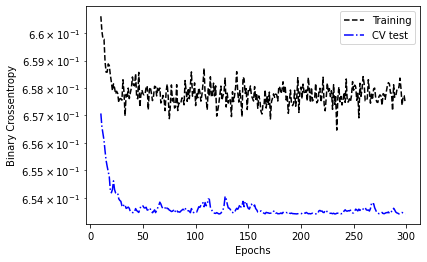

In [292]:
plot_learning_curves(hist_3)

Our NN does not show much potential for improvements. I also tried the sklearn MLP implemenation with nearly the same results. 

# 5. Evaluation of the model predictions

Here we will compare our models on their performance on the test set. On the models we used CV we will train them again on the whole dataset since our dataset is pretty small.

In total we tried 3 different approaches:
- SVC 
- Random Forest
- NN

Here we will compare and summarize all of their performances.

## 5.1 SVC Performance Review

In [313]:
# call our svc models and train them again on the whole dataset

svc_linear.fit(df_Z_std, y_train)
svc_rbf.fit(df_Z_std, y_train)

y_pred_svc_linear = svc_linear.predict(df_Z_test_std)
y_pred_svc_rbf = svc_rbf.predict(df_Z_test_std)

In [315]:
# get the accuracy on the test set:

score_svc_linear = sk.metrics.accuracy_score(y_test, y_pred_svc_linear)
score_svc_rbf = sk.metrics.accuracy_score(y_test, y_pred_svc_rbf)

In [317]:
sk.metrics.confusion_matrix(y_test, y_pred_svc_linear)

array([[12, 10],
       [ 8, 31]], dtype=int64)

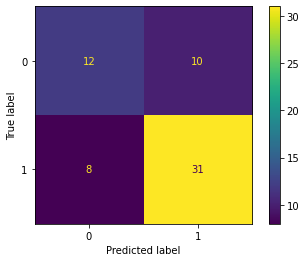

In [323]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc_linear)

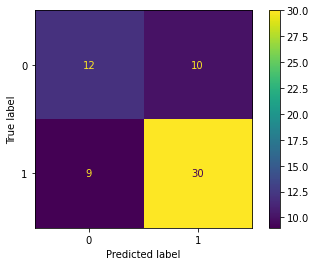

In [324]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc_rbf)

We can see that we are bad in predicting that the mean share price will fall. That may be since our dataset is unbalanced.

# 5.2 Random Forest Performance Review

In [327]:
# call our svc models and train them again on the whole dataset
rf_2 = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    criterion="gini",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=2022
)

rf_2.fit(df_Z_std, y_train)

y_pred_rf_2 = rf_2.predict(df_Z_test_std)

# get the accuracy on the test set:

score_rf_2 = sk.metrics.accuracy_score(y_test, y_pred_rf_2)

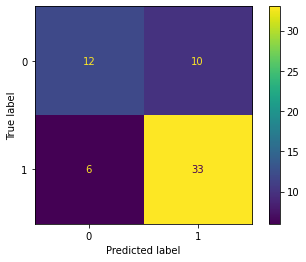

In [328]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_2)

Nearly the same issue like the svc but slightly better performance. We will see the overall performance later.

## 5.3 NN Performance Review

We have seen that our NN is not able to predict class 0. Anyways we will review the performance.

In [329]:
evaluation_3 = model_3.evaluate(df_Z_test_minMax, y_test, verbose=1, return_dict=True)
print("Test Accuracy:", evaluation_3['accuracy'])

2/2 [==============================] - 0s 14ms/step - loss: 0.6538 - accuracy: 0.6393
Test Accuracy: 0.6393442749977112


In [337]:
y_pred_nn = model_3.predict(df_Z_test_minMax)

score_nn = sk.metrics.accuracy_score(y_test, y_pred_nn)

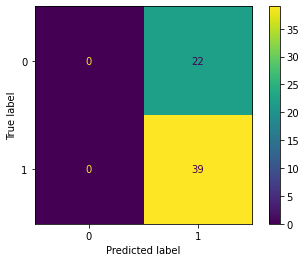

In [338]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn)

## 5.4 Overall Comparison

<BarContainer object of 4 artists>

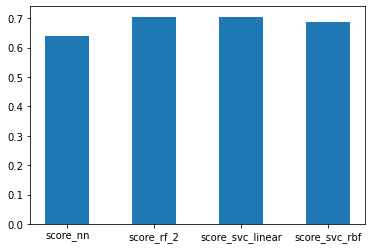

In [350]:
# save results in array:

results = {
    "score_nn":score_nn,
    "score_rf_2": score_rf_2,
    "score_svc_linear": score_svc_linear,
    "score_svc_rbf": score_svc_rbf}

plt.bar(results.keys(), results.values(), width= 0.5)

#df_results.plot.bar( grid = True,ylim = 0.8,figsize = (10,10) )

# 6 Lessons Learnt and Conclusion

What was our goal?
------------------

Our goal was:
- Creating a tool that helps us investing in the right moment.

Our question was: 
- Can we use data driven methods to predict whether the 45 days mean of the apple share price will be higher or lower than the last 45 days?


What did we learn?
------------------

1. Simple is better than complex:
- Our classic ML approaches could outperform the NN and could perform better than randomly guessing (acc = 0.5) or always guessing class 1 (acc = 0.63).
- Our NN could not perform well on our simplified dataset. I suspect that the data set was too small, but I can't rule out the possibility that I made a mistake in the implementation.

2. Complex is better than complicated:
- Eventhough our feature engineering is very complex, it helps us understanding the predictions of our algorithms. We can plot the shapelets and the distances to these shapelets. That helps us explaining our predictions (explainable AI/ XAI). This can be helpful when you're standing in front of your boss at Goldman Sachs trying to explain why you think a $6 million short position on Apple stock is a good idea.

3. The Feature Extraction Model is our weak spot
- We have seen that eventhough hyperparameter tuning and state of the art ML models for binary classification had a limit on this dataset. In my opinion, optimizing the feature extraction algorithm could lead to better data and to higher accuracy of our models.


What we could have done better?
--------------------------------

1. With more time we could have try out different approaches for feature extraction e.g. extracting the local slope of the time series as feature
2. We could try on different datasets. The apple stock was nearly constantly rising the last decade what lead to a imbalanced dataset.
 

Conclusion:
-----------
Our models are better than random guessing and better than always betting on class 1, yet I would not bet my money based on these predictions. There is potential for more!

